In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
# from sklearn.impute import KNNImputer
from scipy.optimize import curve_fit # use for extrapolation
import traceback


%matplotlib inline

In [2]:
WIID= pd.read_excel('WIID_06MAY2020.xlsx')
# remove lines where gini index or quality or country is not reported
WIID = WIID.dropna(how='any', subset=['gini_reported','country','quality'])
# getting data rows with high quality
WIID_average_quality = WIID[(WIID['quality'] == 'High')]
### ??? what is this ???
# sp500_2000to2010 = sp500[sp500['Date'].dt.year.between(2000,2010)
### Reads education data
EDSTATs_data = pd.read_csv ('Edstats_csv/EdStatsData.csv')

In [3]:
### Reads education data
EDSTATs_data = pd.read_csv ('Edstats_csv/EdStatsData.csv')
### ??? why ???
# EDSTATs_data.drop(EDSTATs_data.columns[49] ,axis=1, inplace=True)

In [144]:
### Attempts to select the appropriate parameter representing educaiton
EDSTATs_education = EDSTATs_data[EDSTATs_data['Indicator Name'].str.contains('education', case = False)]
### ??? what is the use of this
# EDSTATs_education['Indicator Name'][WIID['quality'] == 'High']
drop_values = ['male','female']
EDSTATs_education_unisex = EDSTATs_education[~EDSTATs_education['Indicator Name'].str.contains('|'.join(drop_values), case = False)]
EDSTATs_education_unisex['Indicator Name'].unique()

### Selected parameters
# 'Duration of compulsory education (years)'
# 'Early school leavers from primary education, both sexes (number)'
EDSTATs_education_unisex
# EDSTATs_education_unisex[EDSTATs_education_unisex['Indicator Name']=="Duration of compulsory education (years)"]
# EDSTATs_education_unisex[EDSTATs_education_unisex['Indicator Name']=="Early school leavers from primary education, both sexes (number)"]
# par_intrest = ["Enrolment in tertiary education, all programmes, both sexes (number)"]

# par_interest = ['Wittgenstein Projection: Percentage of the population age 25+ by highest level of educational attainment. No Education. Total']
# par_interest = ['Wittgenstein Projection: Percentage of the population age 25+ by highest level of educational attainment. Lower Secondary. Total']
# par_interest = ['Wittgenstein Projection: Percentage of the population age 25+ by highest level of educational attainment. Incomplete Primary. Total']
# par_interest = ['Wittgenstein Projection: Percentage of the population age 25+ by highest level of educational attainment. Post Secondary. Total']
# par_interest = ['Wittgenstein Projection: Percentage of the population age 25+ by highest level of educational attainment. Primary. Total']
par_interest = ['Wittgenstein Projection: Percentage of the population age 25+ by highest level of educational attainment. Upper Secondary. Total']
# par_interest = ['Enrolment in tertiary education, all programmes, both sexes (number)']
# EDSTATs_education_unisex.head()

# EDU=EDSTATs_education_unisex['Country Code'].unique()

# par_intrest = ["Early school leavers from primary education, both sexes (number)"]#"Duration of compulsory education (years)", 
EDSTATs_education_unisex_mod = EDSTATs_education[EDSTATs_education['Indicator Name'].isin(par_interest) ].drop(['Indicator Name'], axis=1).reset_index(drop=True)
# df = EDSTATs_education_unisex_mod
year_cols = [str(num) for num in range(1980, 2018) if num not in [1981]]
EDSTATs_education_unisex_mod_2 = pd.melt(EDSTATs_education_unisex_mod, id_vars=['Country Code'], value_vars=year_cols)
EDSTATs_education_unisex_mod_2 = EDSTATs_education_unisex_mod_2.rename(columns={'variable':'year', 'value':'early leave school'})
EDSTATs_education_unisex_mod_2['year'] = EDSTATs_education_unisex_mod_2.year.astype('int64')
# EDSTATs_education_unisex_mod = EDSTATs_education_unisex_mod.dropna() # removing early leave school nan values 

In [145]:
# function for extrapolation of nan values

# Function to curve fit to the data
def func(x, a, b):#, c, d):
    return a * (x) + b 
#     return a * (x ** 3) + b * (x ** 2) + c * x + d

def extrapolate(df):
# Initial parameter guess, just to kick off the optimization
    guess = (0.5, 0.5)

    # Create copy of data to remove NaNs for curve fitting
    fit_df = df.dropna()

    # Place to store function parameters for each column
    col_params = {}

    # Curve fit each column
    for col in fit_df.columns:
        # Get x & y
        x = fit_df.index.astype(float).values
        y = fit_df[col].values
        # Curve fit column and get curve parameters
        params = curve_fit(func, x, y, guess)
        # Store optimized parameters
        col_params[col] = params[0]

    # Extrapolate each column
    for col in df.columns:
        # Get the index values for NaNs in the column
        x = df[pd.isnull(df[col])].index.astype(float).values
        # Extrapolate those points with the fitted function
#         df[col][x] = func(x, *col_params[col])
        df.loc[x, col] = func(x, *col_params[col])
        
    return df

In [ ]:
### Make clean dataset with filling na values
### rename columns of WIID to align with df column
WIID = WIID.rename(columns={'c3':'Country Code'})
WIID_mod_less_col = WIID.loc[:,['country', 'Country Code', 'year', 'gini_reported', 'scale', 
                         'region_un', 'region_un_sub', 'incomegroup', 'population', 'quality',
                         'quality_score']]
# based on the describe the data after 1980 is used which is last 40 years
WIID_mod_less_col.year.describe() # -->max of data is 2018
WIID_40 = WIID_mod_less_col[WIID_mod_less_col.year >= 1980]
func_dict = {'country':'first','gini_reported':'mean', 'population':'mean', 'quality_score':'mean', 'scale':'first',
            'incomegroup':'first', 'quality':'first', 'region_un':'first', 'region_un_sub':'first'}
WIID_gr_CC_y = WIID_40.groupby(['Country Code', 'year'], as_index=False).agg(func_dict).sort_values(
    by=['Country Code', 'year'], ascending = True)
# WIID_gr_CC_y_index = WIID_gr_CC_y.set_index(['Country Code', 'year'])

# # get unique country  codes (two approaches)
# # A['Country Code']#.value_counts()
# list_country = pd.unique(WIID_gr_CC_y['Country Code'])
# WIID_full_tmp = []
# ignored_countries = []
# for country in list_country:
#     WIID_country = WIID_gr_CC_y[WIID_gr_CC_y['Country Code']==country]
#     new_index = np.arange(1980,2019,1)
#     WIID_country = WIID_country.set_index('year').reindex(new_index).reset_index()
#     WIID_country['Country Code'].fillna(country, inplace =True)#.fillna(method = 'ffill', inplace =True)
#     WIID_full_tmp.append(WIID_country)

# WIID_full_1980 = pd.concat(WIID_full_tmp, ignore_index=True) 


list_country = pd.unique(WIID_gr_CC_y['Country Code'])
number_val_cols = ['gini_reported', 'population', 'quality_score']
non_numeric_cols = ['Country Code', 'country', 'scale', 'incomegroup', 'quality', 'region_un', 'region_un_sub']
WIID_full_tmp = []
ignored_countries = []
for country in list_country:
#     print(country)
    WIID_country = WIID_gr_CC_y[WIID_gr_CC_y['Country Code']==country]
    new_index = np.arange(1980,2019,1)
    WIID_country = WIID_country.set_index('year').reindex(new_index).reset_index()
#     WIID_country['Country Code'].fillna(country, inplace =True)#.fillna(method = 'ffill', inplace =True)
    for member in non_numeric_cols:
        try:
            WIID_country[member] = WIID_country[member].fillna(WIID_country[member].value_counts().index[0])
        except: # if all values of a column are nan
            print('country "{}" column "{}" are all nan values'.format(country, member))
            pass
    # if you get outside th einner part it just repeats values and doesn't perform extrapolate
    WIID_country[number_val_cols] = WIID_country[number_val_cols].interpolate(method='linear', limit_area='inside')#, limit_direction='both')#
    # Turn-off warning for extrapolation function -- later it could be replaced with correct line in line #34 of function definition 
    pd.set_option('mode.chained_assignment', None)
    try:
        WIID_country[number_val_cols] = extrapolate(WIID_country[number_val_cols])
        # if only one value is given, the country is ignored
        WIID_full_tmp.append(WIID_country)
    except:
#         traceback.print_exc()
        ignored_countries.append(country)
#     print(WIID_country)
WIID_full_1980 = pd.concat(WIID_full_tmp, ignore_index=True) 
print('countries in {} column have less than two non-nan numeric values; So, tehy are delted from database'.format(ignored_countries))

# idx = pd.period_range(min(WIID_gr_CC_y.year), max(WIID_gr_CC_y.year))
# WIID_gr_CC_y
# couldn't use
# # fill missed values fro gini_reported, early leave school & els_ratio
# imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
# number_val_cols = ['gini_reported', 'early leave school', 'els_ratio']
# imputed = imputer.fit_transform(WIID_merge_edstats[number_val_cols])
# WIID_merge_imputed = pd.DataFrame(imputed, columns=number_val_cols)

# couldn't use KNNImputer becasue it just replaced values with mean. Don't know why! 
# # from sklearn.impute import SimpleImputer
# # from sklearn.impute import KNNImputer
# # imp = SimpleImputer(missing_values=np.nan, strategy="mean")
# imputer = KNNImputer(n_neighbors=5)#, weights='uniform')#, metric='nan_euclidean')
# WIID_country["gini_reported"] = imputer.fit_transform(WIID_country[["gini_reported"]])#.ravel()


In [ ]:
### merge WIID and df
new_WIID = pd.merge(WIID_full_1980, EDSTATs_education_unisex_mod_2, how='left', on=['Country Code','year'])#, right_on = ['B_c1','c2'])
# drop lines without early leave school values
# new_WIID = new_WIID.dropna(subset=['early leave school'])
# new_WIID_drop = new_WIID.drop(['ratio_top20bottom20','bottom40','q1','q2','q3','q4','q5','d1','d2','d3','d4','d5','d6','d7','d8','d9','d10','bottom5','top5', 'mean','median','currency','reference_period','mean_usd','median_usd'], axis=1)
# new_WIID_drop_FLT=new_WIID_drop[(new_WIID_drop['year'].between(2004,2014))]#&(new_WIID_drop['quality']=='High')&(new_WIID_drop['quality_score']>8)]#&(new_WIID_drop['scale']=='Per capita')]#&(new_WIID_drop['Country Code']=='GTM')
# # new_WIID_drop_FLT[(new_WIID_drop_FLT['Country Code']=='MEX')]
# new_WIID_drop_FLT

# Get a selection of the columns
WIID_merge_edstats = new_WIID.loc[:,['country', 'Country Code', 'year', 'gini_reported', 'scale', 
                         'region_un', 'region_un_sub', 'incomegroup', 'population', 'quality',
                         'quality_score', 'early leave school']]
# defines ratio of 'early school leave' to  to population
WIID_merge_edstats['els_ratio'] = WIID_merge_edstats['early leave school'] / WIID_merge_edstats['population']

list_countries = pd.unique(WIID_merge_edstats['Country Code'])
number_val_cols = ['early leave school', 'els_ratio']#['gini_reported', 'population', 'quality_score','early leave school', 'els_ratio']
non_numeric_cols = [] #['Country Code', 'country', 'scale', 'incomegroup', 'quality', 'region_un', 'region_un_sub']
WIID_merge_full_tmp = []
ignored_countries = []
for country in list_countries:
    WIID_merge_country = WIID_merge_edstats[WIID_merge_edstats['Country Code']==country]
    for member in non_numeric_cols:
        try:
            WIID_merge_country[member] = WIID_merge_country[member].fillna(WIID_merge_country[member].value_counts().index[0])
        except: # if all values of a column are nan
            print('country "{}" column "{}" are all nan values'.format(country, member))
            pass
#     if you get outside th einner part it just repeats values and doesn't perform extrapolate
    WIID_merge_country[number_val_cols] = WIID_merge_country[number_val_cols].interpolate(method='linear', limit_area='inside')#, limit_direction='both')#
    # Turn-off warning for extrapolation function -- later it could be replaced with correct line in line #34 of function definition 
    pd.set_option('mode.chained_assignment', None)
    try:
        WIID_merge_country[number_val_cols] = extrapolate(WIID_merge_country[number_val_cols])
        # if only one value is given, the country is ignored
        WIID_merge_full_tmp.append(WIID_merge_country)
    except:
#         traceback.print_exc()
        ignored_countries.append(country)
WIID_merge_full_1980 = pd.concat(WIID_merge_full_tmp, ignore_index=True) 
print('countries in {} column have less than two non-nan numeric values; So, tehy are delted from database'.format(ignored_countries))


In [148]:
list(EDSTATs_education_unisex[EDSTATs_education_unisex['Country Code'] == 'USA']['Indicator Name'])
# EDSTATs_education_unisex.iloc[0,:]
# EDSTATs_education.columns
A = EDSTATs_education_unisex.dropna(thresh=20)
# A['Indicator Name'].value_counts()[30:60]


__Note:__
The problem here is that there are countries with less thna two non-nan values in gini index:
'ARE', 'BHR', 'BRN', 'DMA', 'GNQ', 'KIR', 'MMR', 'PLW', 'SDN', 'SOM', 'SSD', 'TCA', 'TUV', 'VUT'  
Also, there countries without 'esl_ratio', these are also left out:
'AND', 'AUS', 'CSK', 'FSM', 'GBR', 'GRD', 'GRL', 'IRL', 'LBR', 'LBY', 'LUX', 'MNE', 'NZL', 'PRI', 'PRT', 'SCG', 'SLE', 'SUN', 'TKM', 'TWN', 'USA', 'VCT', 'XKX', 'YUG'

<Figure size 3000x2000 with 0 Axes>

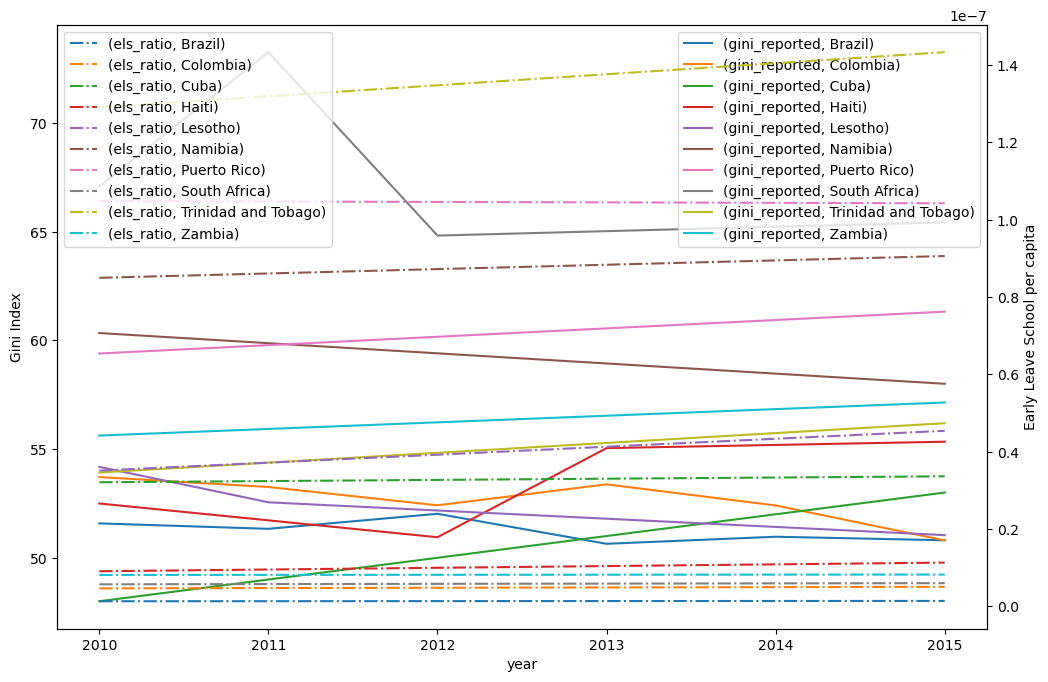

<Figure size 3000x2000 with 0 Axes>

In [149]:
# finds 10 countries with highest 10 year average gini index from 2000 on
WIID_merge_full_1980_10 = WIID_merge_full_1980[WIID_merge_full_1980.year >= 2010]
sort_df_10_country = WIID_merge_full_1980_10.groupby(['Country Code'])[['gini_reported']].mean().sort_values(by='gini_reported', ascending=False)
# list of conutry code with highest 10-year gini average
country_list_10_gini = sort_df_10_country.index[:10]
# a = df.groupby('A')['B'].mean().sort_values(ascending=False)
new_WIID_drop_10 = WIID_merge_full_1980[WIID_merge_full_1980['Country Code'].isin(country_list_10_gini)]
new_WIID_drop_10 = new_WIID_drop_10[new_WIID_drop_10.year.between(2010,2015)]
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
# fig = new_WIID_drop_10.groupby(['year', 'country'])[['gini_reported','els_ratio']].mean().unstack().plot(kind='line')
###
# scaling two columns 
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df_tmp = new_WIID_drop_10
# df_tmp[['gini_reported','els_ratio']] = scaler.fit_transform(new_WIID_drop_10.groupby(['year', 'country'])[['gini_reported','els_ratio']].mean())
fig = plt.figure()
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
new_WIID_drop_10.groupby(['year', 'country'])[['gini_reported']].mean().unstack().plot(kind='line', ax=ax, legend=True)
new_WIID_drop_10.groupby(['year', 'country'])[['els_ratio']].mean().unstack().plot(kind='line', ax=ax2, style='-.')

# fig = df_tmp.groupby(['year', 'country'])[['gini_reported']].mean().unstack().plot(kind='line')
ax.set_ylabel('Gini Index')
ax2.set_ylabel('Early Leave School per capita')

ax.legend(loc='upper right')
ax2.legend(loc='upper left')
# ax2.set_ylim([0,0.005])
# plt.savefig('10_lowest_gini_els_1.png', dpi=100)
# plt.legend(bbox_to_anchor=(1.1, 1.))
plt.figure(figsize=(30,20))

<Figure size 3000x2000 with 0 Axes>

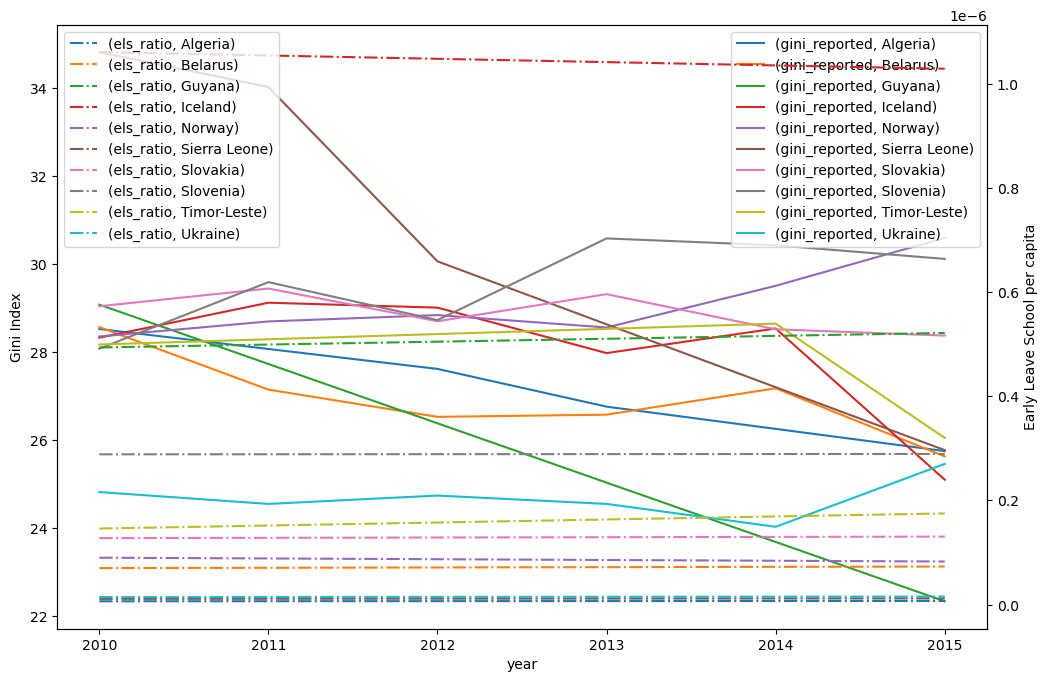

<Figure size 3000x2000 with 0 Axes>

In [151]:
# finds 10 countries with highest 10 year average gini index from 2000 on
WIID_merge_full_1980_10 = WIID_merge_full_1980[WIID_merge_full_1980.year >= 2010]
sort_df_10_country = WIID_merge_full_1980_10.groupby(['country'])[['gini_reported']].mean().sort_values(by='gini_reported', ascending=True)
# list of conutry code with highest 10-year gini average
country_list_10_gini = sort_df_10_country.index[:10]
# a = df.groupby('A')['B'].mean().sort_values(ascending=False)
# new_WIID_drop_10 = WIID_merge_full_1980[WIID_merge_full_1980['Country Code'].isin(country_list_10_gini)]
# sort 10 countries
new_WIID_10_sort =[]
for ind in country_list_10_gini:
    df_tmp = WIID_merge_full_1980[WIID_merge_full_1980['country'] == ind]
    new_WIID_10_sort.append(df_tmp)
new_WIID_drop_10 = pd.concat(new_WIID_10_sort, ignore_index=True).reset_index(drop=True) 
new_WIID_drop_10 = new_WIID_drop_10[new_WIID_drop_10.year.between(2010,2015)]
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
# fig = new_WIID_drop_10.groupby(['year', 'country'])[['gini_reported','els_ratio']].mean().unstack().plot(kind='line')
###
# scaling two columns 
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df_tmp = new_WIID_drop_10
# df_tmp[['gini_reported','els_ratio']] = scaler.fit_transform(new_WIID_drop_10.groupby(['year', 'country'])[['gini_reported','els_ratio']].mean())

df_tmp_WIID_10_gini = new_WIID_drop_10.groupby(['year', 'country'], as_index=False)[['gini_reported']].mean()#.unstack().plot(kind='line', ax=ax2, style='-.', legend=True)
sorterIndex = dict(zip(country_list_10_gini, range(len(country_list_10_gini))))
df_tmp_WIID_10_gini['CC_ind'] = df_tmp_WIID_10_gini['country'].map(sorterIndex)
df_tmp_WIID_10_gini = df_tmp_WIID_10_gini.sort_values(by=['year','CC_ind'])
df_tmp_WIID_10_gini.set_index(['year', 'country'], inplace=True)

fig = plt.figure()
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
# new_WIID_drop_10.groupby(['year', 'country'])[['gini_reported']].mean().unstack().plot(kind='line', ax=ax, legend=True)

df_tmp_WIID_10_gini[['gini_reported']].unstack().plot(kind='line', ax=ax, style='-', legend=True)
new_WIID_drop_10.groupby(['year', 'country'])[['els_ratio']].mean().unstack().plot(kind='line', ax=ax2, style='-.', legend=True)

# fig = df_tmp.groupby(['year', 'country'])[['gini_reported']].mean().unstack().plot(kind='line')
ax.set_ylabel('Gini Index')
ax2.set_ylabel('Early Leave School per capita')

ax.legend(loc='upper right')
ax2.legend(loc='upper left')
# ax2.set_ylim([0,0.005])
# plt.savefig('10_highest_gini_els_1.png', dpi=100)
# plt.legend(bbox_to_anchor=(1.1, 1.))
plt.figure(figsize=(30,20))

<Figure size 3000x2000 with 0 Axes>

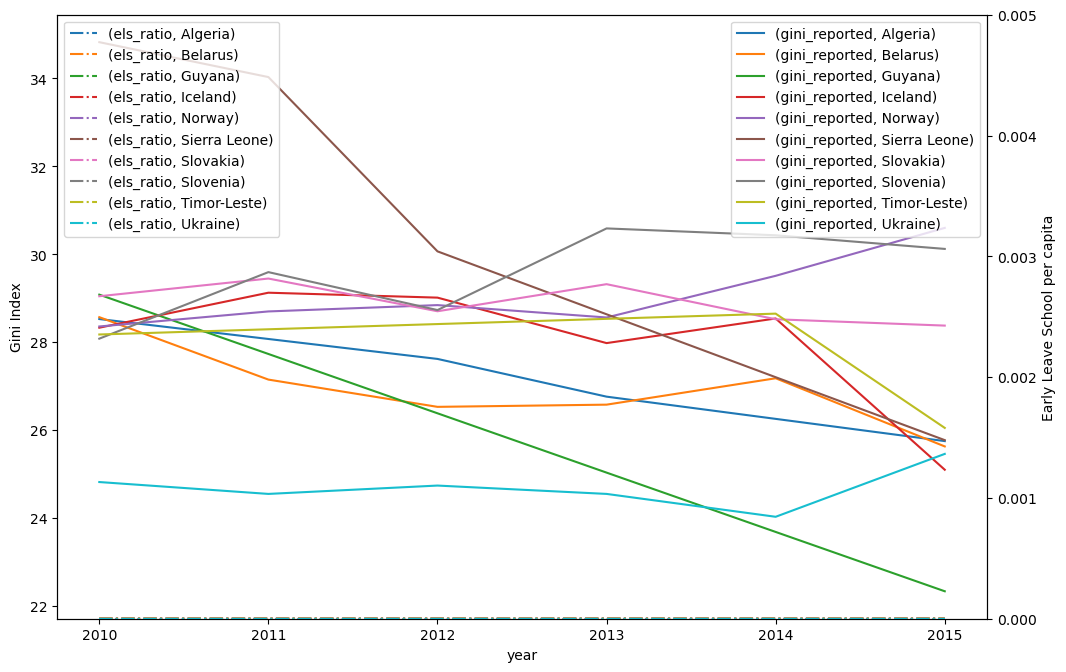

<Figure size 3000x2000 with 0 Axes>

In [152]:
# finds 10 countries with highest 10 year average gini index from 2000 on
# finds 10 countries with highest 10 year average gini index from 2000 on
WIID_merge_full_1980_10 = WIID_merge_full_1980[WIID_merge_full_1980.year >= 2005]
sort_df_10_country_low = WIID_merge_full_1980_10.groupby(['country'])[['gini_reported','els_ratio']].mean().sort_values(by='gini_reported', ascending=True)
# list of conutry code with highest 10-year gini average
sort_df_10_country_high = WIID_merge_full_1980_10.groupby(['country'])[['gini_reported','els_ratio']].mean().sort_values(by='gini_reported', ascending=False)

country_list_10_high = sort_df_10_country_high.index[:5]
country_list_10_low = sort_df_10_country_low.index[:5]

# new_WIID_drop_10 = WIID_merge_full_1980[WIID_merge_full_1980['Country Code'].isin(country_list_10_gini)]
# sort 10 countries
new_WIID_10_sort_high =[]
new_WIID_10_sort_low =[]
for ind in country_list_10_high:
    df_tmp = WIID_merge_full_1980[WIID_merge_full_1980['country'] == ind]
    new_WIID_10_sort_high.append(df_tmp)
new_WIID_drop_10 = pd.concat(new_WIID_10_sort, ignore_index=True).reset_index(drop=True) 
new_WIID_drop_10 = new_WIID_drop_10[new_WIID_drop_10.year.between(2010,2015)]
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
# fig = new_WIID_drop_10.groupby(['year', 'country'])[['gini_reported','els_ratio']].mean().unstack().plot(kind='line')
###
# scaling two columns 
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df_tmp = new_WIID_drop_10
# df_tmp[['gini_reported','els_ratio']] = scaler.fit_transform(new_WIID_drop_10.groupby(['year', 'country'])[['gini_reported','els_ratio']].mean())

df_tmp_WIID_10_gini = new_WIID_drop_10.groupby(['year', 'country'], as_index=False)[['gini_reported']].mean()#.unstack().plot(kind='line', ax=ax2, style='-.', legend=True)
sorterIndex = dict(zip(country_list_10_gini, range(len(country_list_10_gini))))
df_tmp_WIID_10_gini['CC_ind'] = df_tmp_WIID_10_gini['country'].map(sorterIndex)
df_tmp_WIID_10_gini = df_tmp_WIID_10_gini.sort_values(by=['year','CC_ind'])
df_tmp_WIID_10_gini.set_index(['year', 'country'], inplace=True)

fig = plt.figure()
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
# new_WIID_drop_10.groupby(['year', 'country'])[['gini_reported']].mean().unstack().plot(kind='line', ax=ax, legend=True)

df_tmp_WIID_10_gini[['gini_reported']].unstack().plot(kind='line', ax=ax, style='-', legend=True)
new_WIID_drop_10.groupby(['year', 'country'])[['els_ratio']].mean().unstack().plot(kind='line', ax=ax2, style='-.', legend=True)

# fig = df_tmp.groupby(['year', 'country'])[['gini_reported']].mean().unstack().plot(kind='line')
ax.set_ylabel('Gini Index')
ax2.set_ylabel('Early Leave School per capita')

ax.legend(loc='upper right')
ax2.legend(loc='upper left')
ax2.set_ylim([0,0.005])
# plt.savefig('10_highest_gini_els_1.png', dpi=100)
# plt.legend(bbox_to_anchor=(1.1, 1.))
plt.figure(figsize=(30,20))

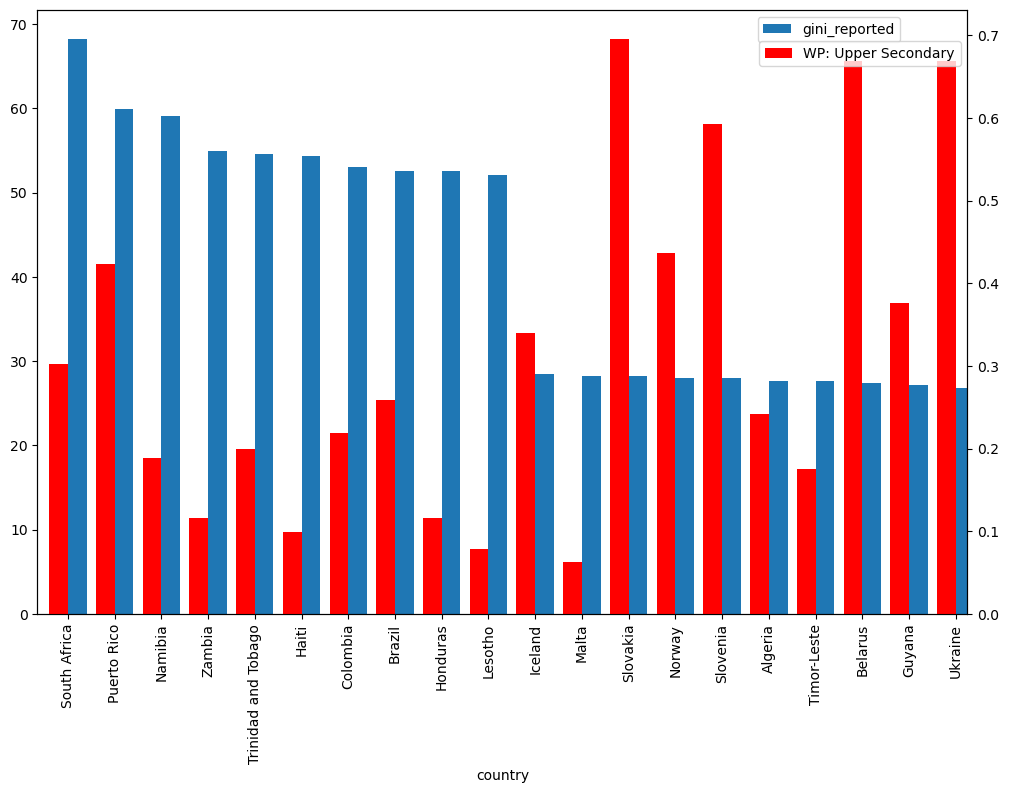

In [157]:
# finds 10 countries with highest 10 year average gini index from 2000 on
# finds 10 countries with highest 10 year average gini index from 2000 on
   
WIID_merge_full_1980_10 = WIID_merge_full_1980[WIID_merge_full_1980.year >= 2005]
# list of conutry code with highest 10-year gini average
sort_df_10_country_high = WIID_merge_full_1980_10.groupby(['country'])[['gini_reported','early leave school','els_ratio']].mean().sort_values(by='gini_reported', ascending=False)

# sort_df_10_country_high.head(5).reset_index().plot(x='country', y=['gini_reported','els_ratio'], kind='bar')
fig = plt.figure()
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
####
# Heiti is an outlier which is neglected. Should be investigated.
sort_df_10_country_high.iloc[np.r_[0:10,-10:0]].reset_index().plot(x='country', y=['gini_reported'], ax=ax, kind='bar', width=0.4, position=0)
sort_df_10_country_high.iloc[np.r_[0:10,-10:0]].reset_index().plot(x='country', y=['early leave school'], ax=ax2, kind='bar', color='red',position=1, width=0.4, label=['WP: Upper Secondary'])#, position=1)
ax.legend(loc=0)
ax.legend(loc=1, bbox_to_anchor=(0.935, 1))
ax2.legend(loc=1, bbox_to_anchor=(1, 0.96))
plt.savefig('1upp_secondary.png', dpi=100)


In [ ]:
import plotly.express as px
data_canada = px.data.gapminder().query("country == 'Canada'")
fig = px.bar(data_canada, x='year', y='pop')
fig.show()

In [ ]:
df_tmp = WIID_merge_full_1980[WIID_merge_full_1980['Country Code'] == 'SWE']
fig = plt.figure()
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

df_tmp.gini_reported.diff(10).plot(kind='bar', color='red', ax=ax, width=width, position=1)
# df_tmp.els_ratio.diff().plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('Gini Index')
ax2.set_ylabel('Early Leave School per capita')
plt.legend(loc=0)
plt.show()

In [ ]:
df_tmp_USA = WIID[(WIID['Country Code'] == 'USA') & (WIID.year > 2000)]
df_tmp_CHN = WIID[(WIID['Country Code'] == 'CHN') & (WIID.year > 2000)]

fig = plt.figure()
ax = fig.add_subplot(111) # Create matplotlib axes
# ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

df_tmp_USA.gini_reported.pct_change().plot(kind='bar', color='red', ax=ax, width=width)
df_tmp_CHN.gini_reported.pct_change().plot(kind='bar', color='blue', ax=ax, width=width)

ax.set_ylabel('Gini Index')
ax2.set_ylabel('Early Leave School per capita')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# average gorwth US versus China


In [ ]:
import seaborn as sns
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
fig = new_WIID_drop_FLT.groupby(['year', 'Country Code'])[['gini_reported']].mean().unstack().plot(kind='line')
plt.legend(loc='best')
plt.figure(figsize=(30,20))


In [ ]:
gini_avg_country = new_WIID_drop_FLT[new_WIID_drop_FLT['year']==2014.groupby(['Country Code']).mean().drop(['id'], axis=1)#.astype({'year':'int'})
gini_avg_country
new_WIID_drop_FLT[(new_WIID_drop_FLT['year']==2014)&new_WIID_drop_FLT.groupby(['Country Code'])[['gini_reported']].mean()].nlargest(10, ['gini_reported'])
# ax = plt.gca()
# new_WIID_drop_FLT=new_WIID_drop[(new_WIID_drop['year'].between(2004,2014))]
# gini_avg_country.plot(kind='line',x='year',y='gini_reported',ax=ax)
# # gini_avg_country.plot(kind='line',x='year',y='num_pets', color='red', ax=ax)

# plt.show()

In [ ]:
ten_max_gini_WIID = new_WIID_drop_FLT[(new_WIID_drop_FLT['year']==2014)&(new_WIID_drop_FLT['quality']=='High')].nlargest(10, ['gini_reported'])
pd.set_option('display.max_columns', None)
ten_max_gini_WIID#[ten_max_gini_WIID['Country Code']=='COL']